
# Earthquake Time Series Forecasting and Anomaly Detection

This notebook demonstrates **time series forecasting and anomaly detection** using earthquake data.  
We will cover the following steps:
- Exploratory Data Analysis (EDA)
- Time Series Transformation
- Stationarity Check
- Forecasting Models (ARIMA, LSTM, Hybrid LSTM)
- Model Comparison
- Anomaly Detection (IQR, Z-score, Forecast Residuals)


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## 1. Data Loading and Preprocessing

In [2]:

# Load Dataset
df = pd.read_csv("Dataset.csv")

# Combine Date and Time
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'], errors='coerce')

# Select relevant columns
df = df[['Datetime', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
df = df.dropna().sort_values(by="Datetime").reset_index(drop=True)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (23409, 5)


,Datetime,Latitude,Longitude,Depth,Magnitude
0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0
1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8
2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2
3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8
4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8


### Creating Monthly Aggregated Time Series

In [3]:
# Resample to Monthly Data and Feature Engineering
monthly_data = df.resample('M', on='Datetime').mean(numeric_only=True)
monthly_data = monthly_data.fillna(method='ffill')

# Feature Engineering: Lag Features
monthly_data['Magnitude_lag1'] = monthly_data['Magnitude'].shift(1)
monthly_data['Depth_lag1'] = monthly_data['Depth'].shift(1)

# Rolling Statistics
monthly_data['Magnitude_roll3_mean'] = monthly_data['Magnitude'].rolling(window=3).mean()
monthly_data['Magnitude_roll3_std'] = monthly_data['Magnitude'].rolling(window=3).std()
monthly_data['Depth_roll3_mean'] = monthly_data['Depth'].rolling(window=3).mean()
monthly_data['Depth_roll3_std'] = monthly_data['Depth'].rolling(window=3).std()

# Time Encoding
monthly_data['Month'] = monthly_data.index.month
monthly_data['Year'] = monthly_data.index.year

# Drop initial rows with NaN from lag/rolling features
monthly_data = monthly_data.dropna().copy()
monthly_data.head()

,Latitude,Longitude,Depth,Magnitude,Magnitude_lag1,Depth_lag1,Magnitude_roll3_mean,Magnitude_roll3_std,Depth_roll3_mean,Depth_roll3_std,Month,Year
Datetime,,,,,,,,,,,,
1965-03-31,13.048763,42.257000,62.055263,6.057895,5.955556,47.712963,6.045509,0.084445,70.294537,27.638178,3,1965
1965-04-30,10.929121,34.341424,112.163636,5.945455,6.057895,62.055263,5.986302,0.062207,73.977287,33.838932,4,1965
1965-05-31,4.530727,72.525636,80.972727,5.954545,5.945455,112.163636,5.985965,0.062459,85.063876,25.303466,5,1965
1965-06-30,21.651844,81.956344,49.165625,5.906250,5.954545,80.972727,5.935417,0.025665,80.767330,31.499508,6,1965
1965-07-31,16.464857,39.284714,93.919048,5.923810,5.906250,49.165625,5.928202,0.024445,74.685800,23.029574,7,1965


## 2. Exploratory Data Analysis (EDA)

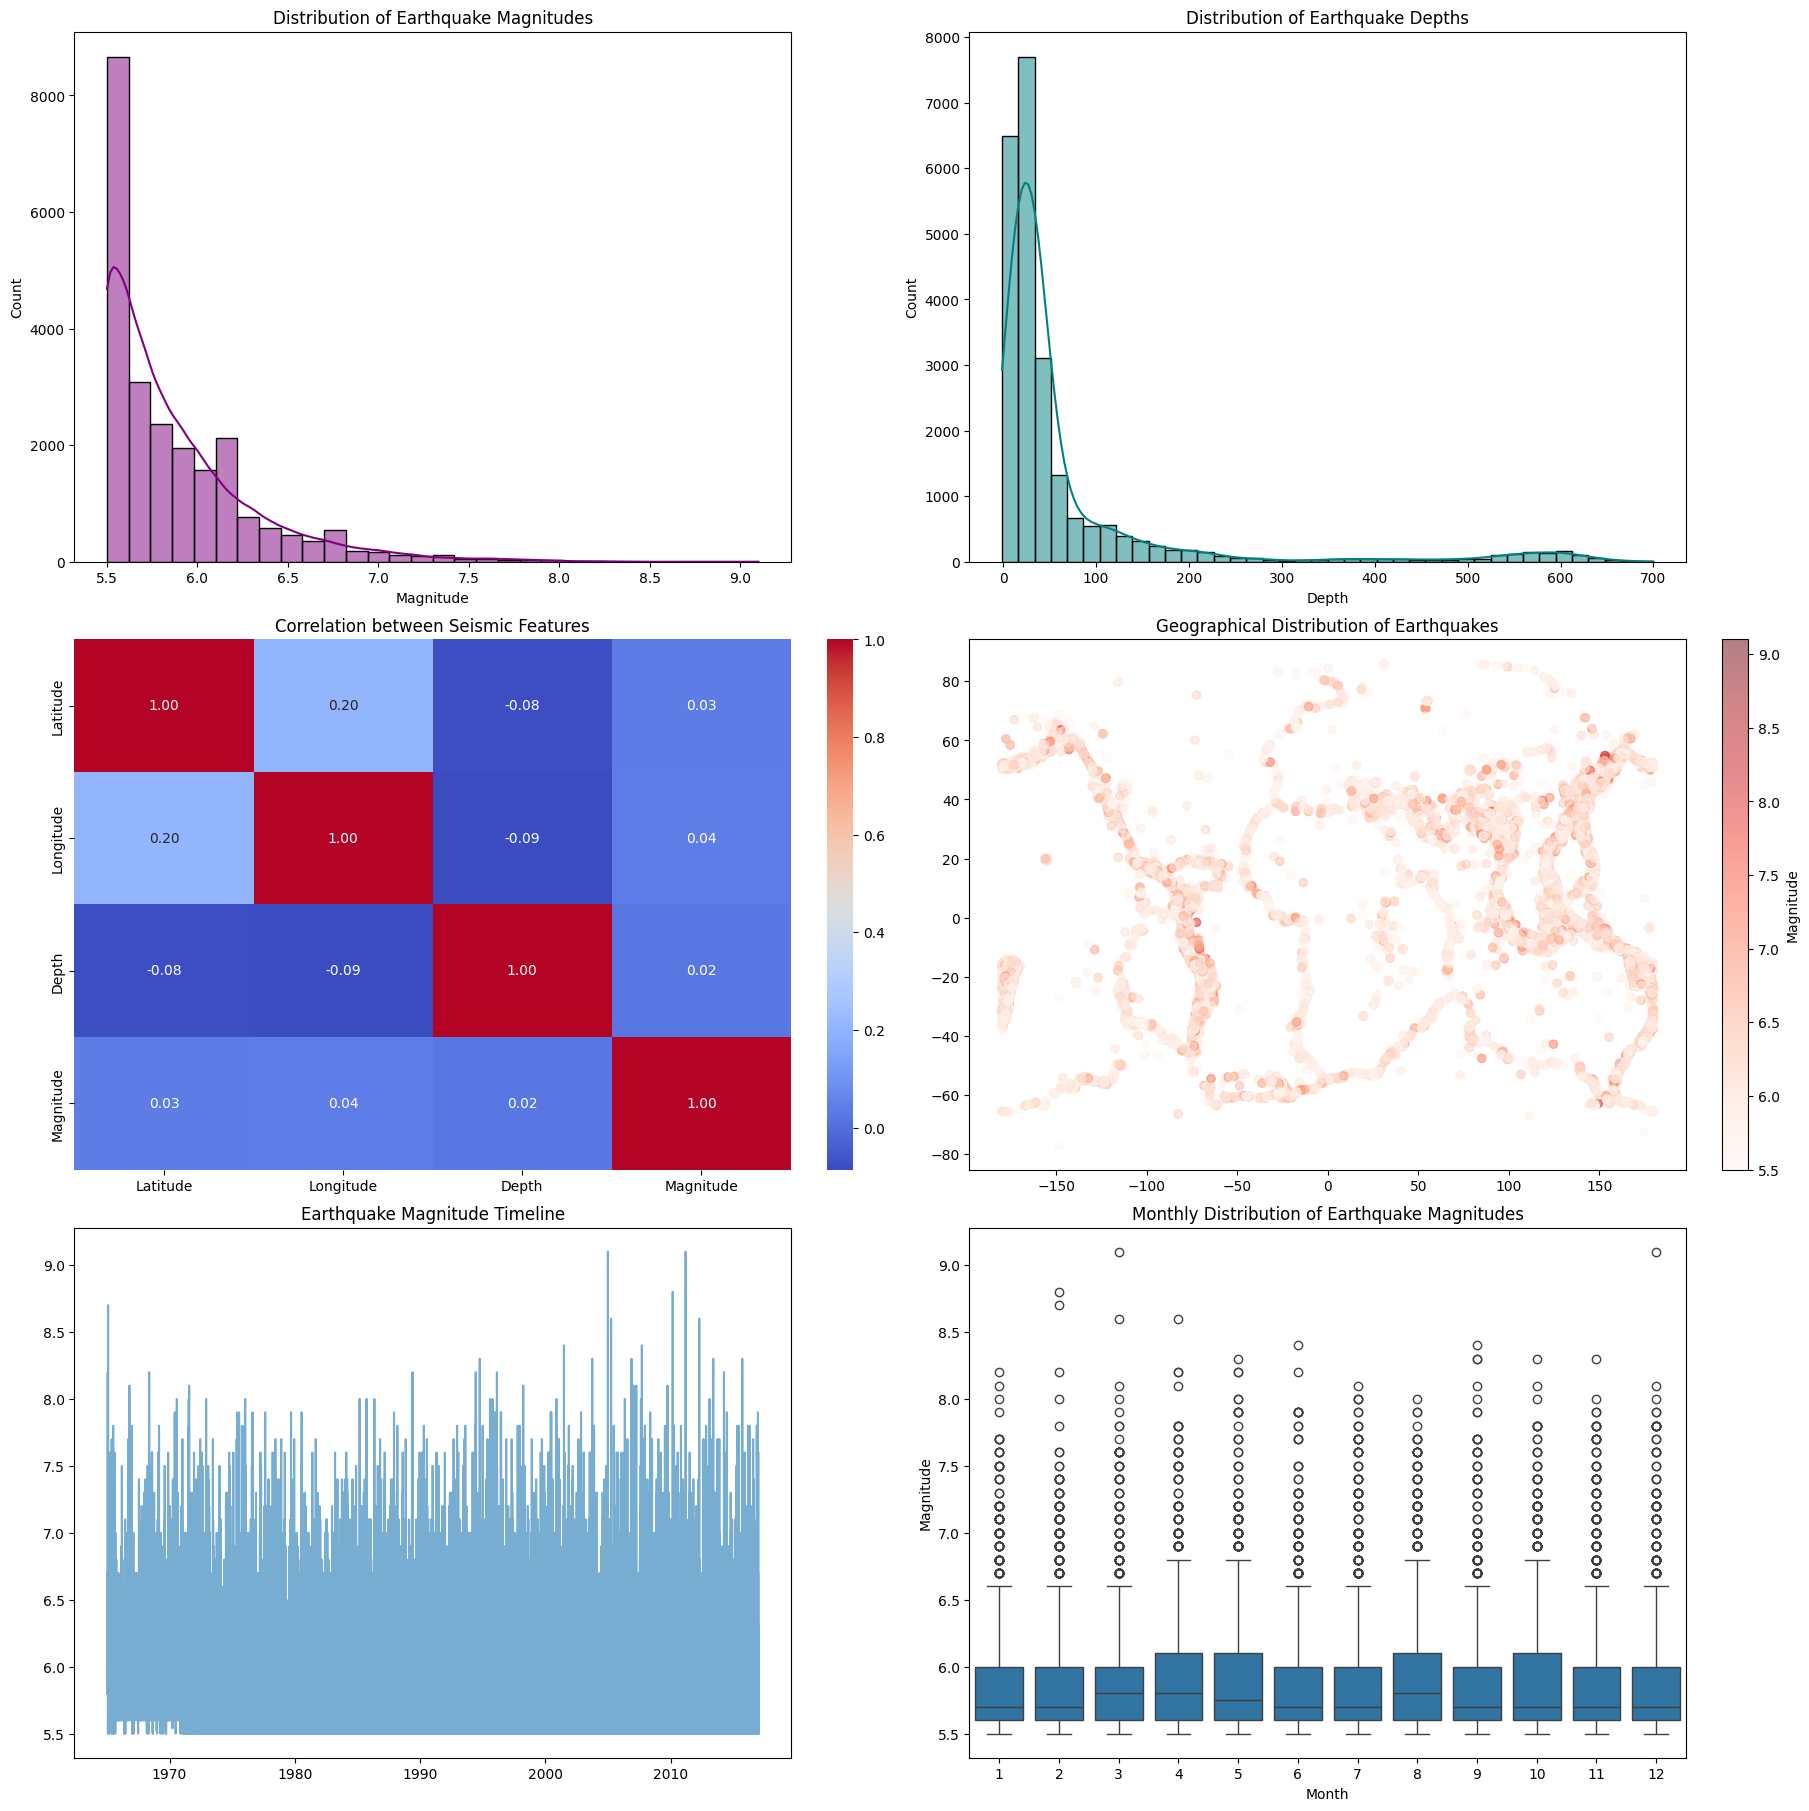

In [4]:
# Exploratory Data Analysis (EDA) - Subplots
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(18, 18))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Magnitude Distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df['Magnitude'], bins=30, kde=True, color='purple', ax=ax1)
ax1.set_title('Distribution of Earthquake Magnitudes')

# Depth Distribution
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df['Depth'], bins=40, kde=True, color='teal', ax=ax2)
ax2.set_title('Distribution of Earthquake Depths')

# Correlation Heatmap
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(df[['Latitude','Longitude','Depth','Magnitude']].corr(), annot=True, cmap='coolwarm', fmt='.2f', ax=ax3)
ax3.set_title('Correlation between Seismic Features')

# Earthquake Locations Scatter Plot
ax4 = fig.add_subplot(gs[1, 1])
sc = ax4.scatter(df['Longitude'], df['Latitude'], c=df['Magnitude'], cmap='Reds', alpha=0.5)
plt.colorbar(sc, ax=ax4, label='Magnitude')
ax4.set_title('Geographical Distribution of Earthquakes')

# Magnitude Over Time
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(df['Datetime'], df['Magnitude'], alpha=0.6)
ax5.set_title('Earthquake Magnitude Timeline')

# Monthly Magnitude Boxplot
df['Month'] = df['Datetime'].dt.month
ax6 = fig.add_subplot(gs[2, 1])
sns.boxplot(x='Month', y='Magnitude', data=df, ax=ax6)
ax6.set_title('Monthly Distribution of Earthquake Magnitudes')

plt.show()

## 3. Stationarity Check (ADF Test)

In [5]:

result = adfuller(monthly_data['Magnitude'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("Series is Stationary")
else:
    print("Series is Non-Stationary ")


ADF Statistic: -2.574989290983832
p-value: 0.09827743002311168
Series is Non-Stationary 


## 4. Forecasting Models

C:\Users\drahe\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\drahe\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\drahe\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\drahe\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\drahe\AppData\R

Best ARIMA order: (0, 1, 1) with AIC: -1064.61


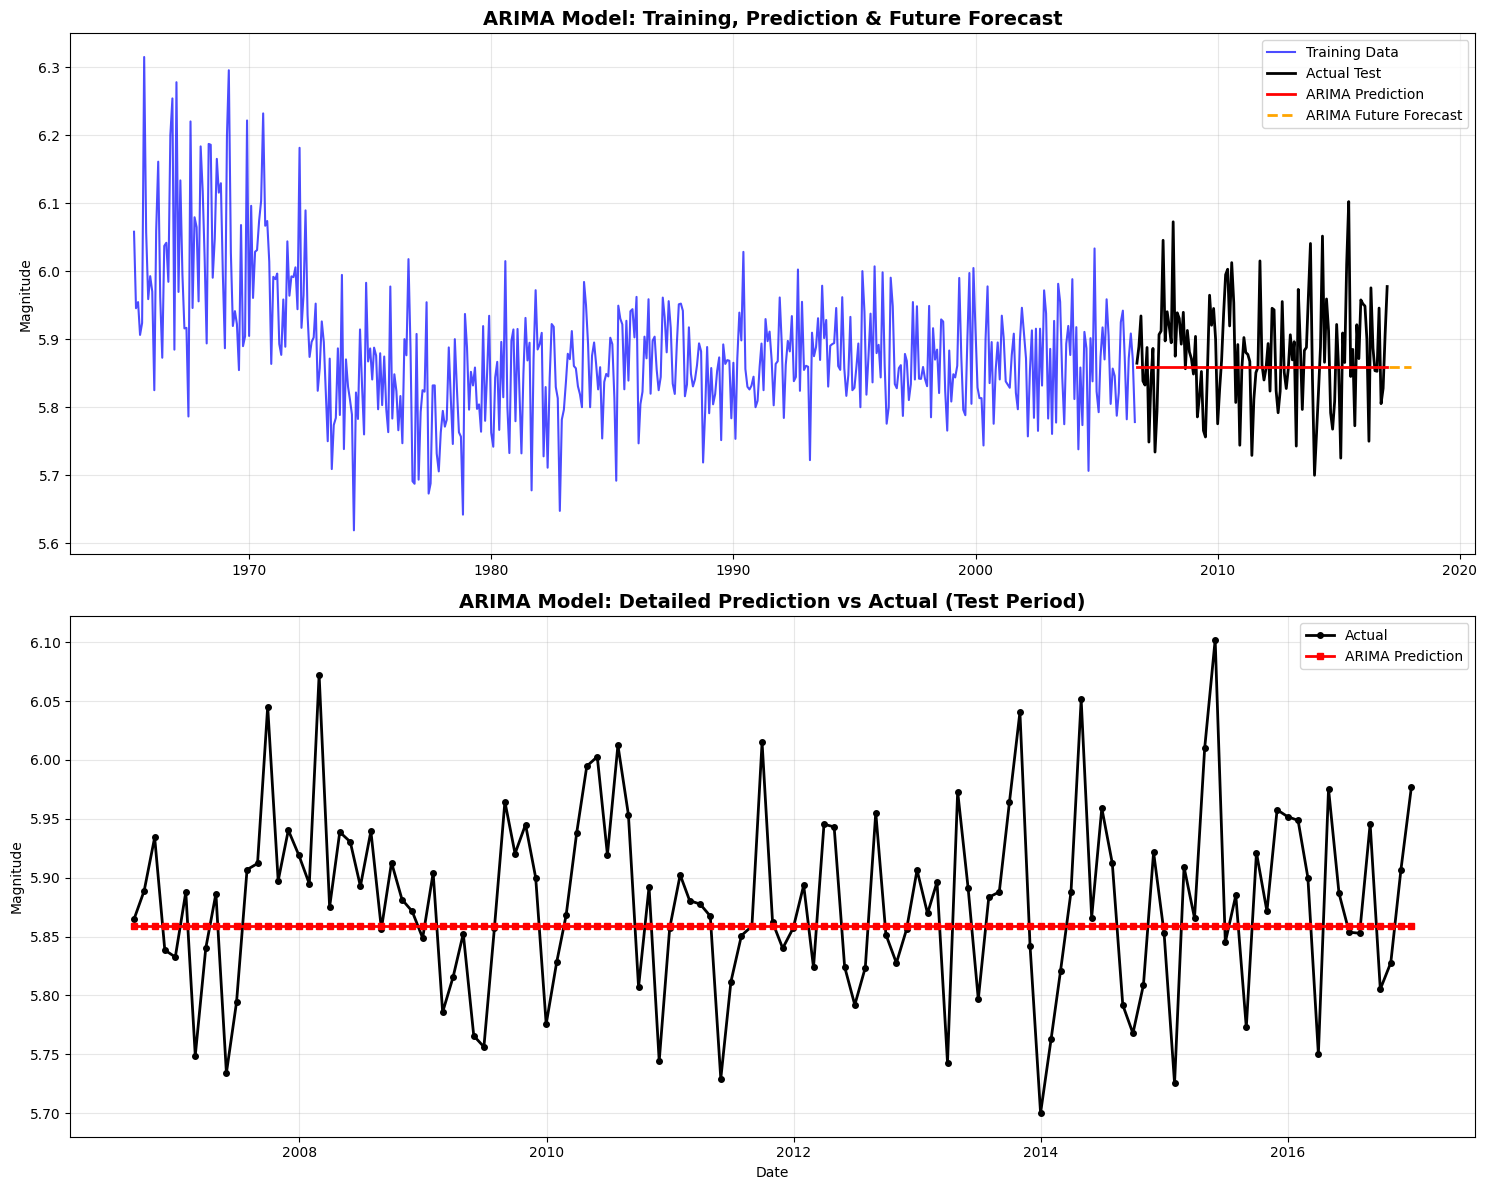

In [6]:
# Optimized ARIMA Model (Grid Search for Best Order)
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt

# Ensure matplotlib backend is set correctly
plt.ion()  # Turn on interactive mode

train_size = int(len(monthly_data) * 0.8)
train, test = monthly_data['Magnitude'][:train_size], monthly_data['Magnitude'][train_size:]

# Grid search for best (p,d,q) based on AIC
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
best_aic = float('inf')
best_order = None
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue
print(f'Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')

# Fit best ARIMA model
model_arima = ARIMA(train, order=best_order)
arima_fit = model_arima.fit()

# Generate predictions and forecasts
forecast_arima = arima_fit.forecast(steps=len(test))
future_forecast_steps = 12  # Forecast 12 months into the future
future_forecast = arima_fit.forecast(steps=len(test) + future_forecast_steps)

# Create time indices for plotting
test_index = test.index
future_index = pd.date_range(start=monthly_data.index[-1], periods=future_forecast_steps+1, freq='MS')[1:]

# Enhanced plotting with prediction and forecast
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Full time series with train, test, and forecast
ax1.plot(train.index, train, label="Training Data", color='blue', alpha=0.7)
ax1.plot(test.index, test, label="Actual Test", color='black', linewidth=2)
ax1.plot(test.index, forecast_arima[:len(test)], label="ARIMA Prediction", color='red', linewidth=2)
ax1.plot(future_index, future_forecast[len(test):], label="ARIMA Future Forecast", color='orange', linewidth=2, linestyle='--')

ax1.set_title("ARIMA Model: Training, Prediction & Future Forecast", fontsize=14, fontweight='bold')
ax1.set_ylabel("Magnitude")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Focus on prediction vs actual (test period only)
ax2.plot(test.index, test, label="Actual", color='black', linewidth=2, marker='o', markersize=4)
ax2.plot(test.index, forecast_arima[:len(test)], label="ARIMA Prediction", color='red', linewidth=2, marker='s', markersize=4)
ax2.set_title("ARIMA Model: Detailed Prediction vs Actual (Test Period)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Magnitude")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0319 - val_loss: 0.0139
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0319 - val_loss: 0.0139
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0178 - val_loss: 0.0128
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0178 - val_loss: 0.0128
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0160 - val_loss: 0.0128
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0160 - val_loss: 0.0128
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0169 - val_loss: 0.0136
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0169 - val_loss: 0.0136
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0162 - val_loss: 0.0130
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0162

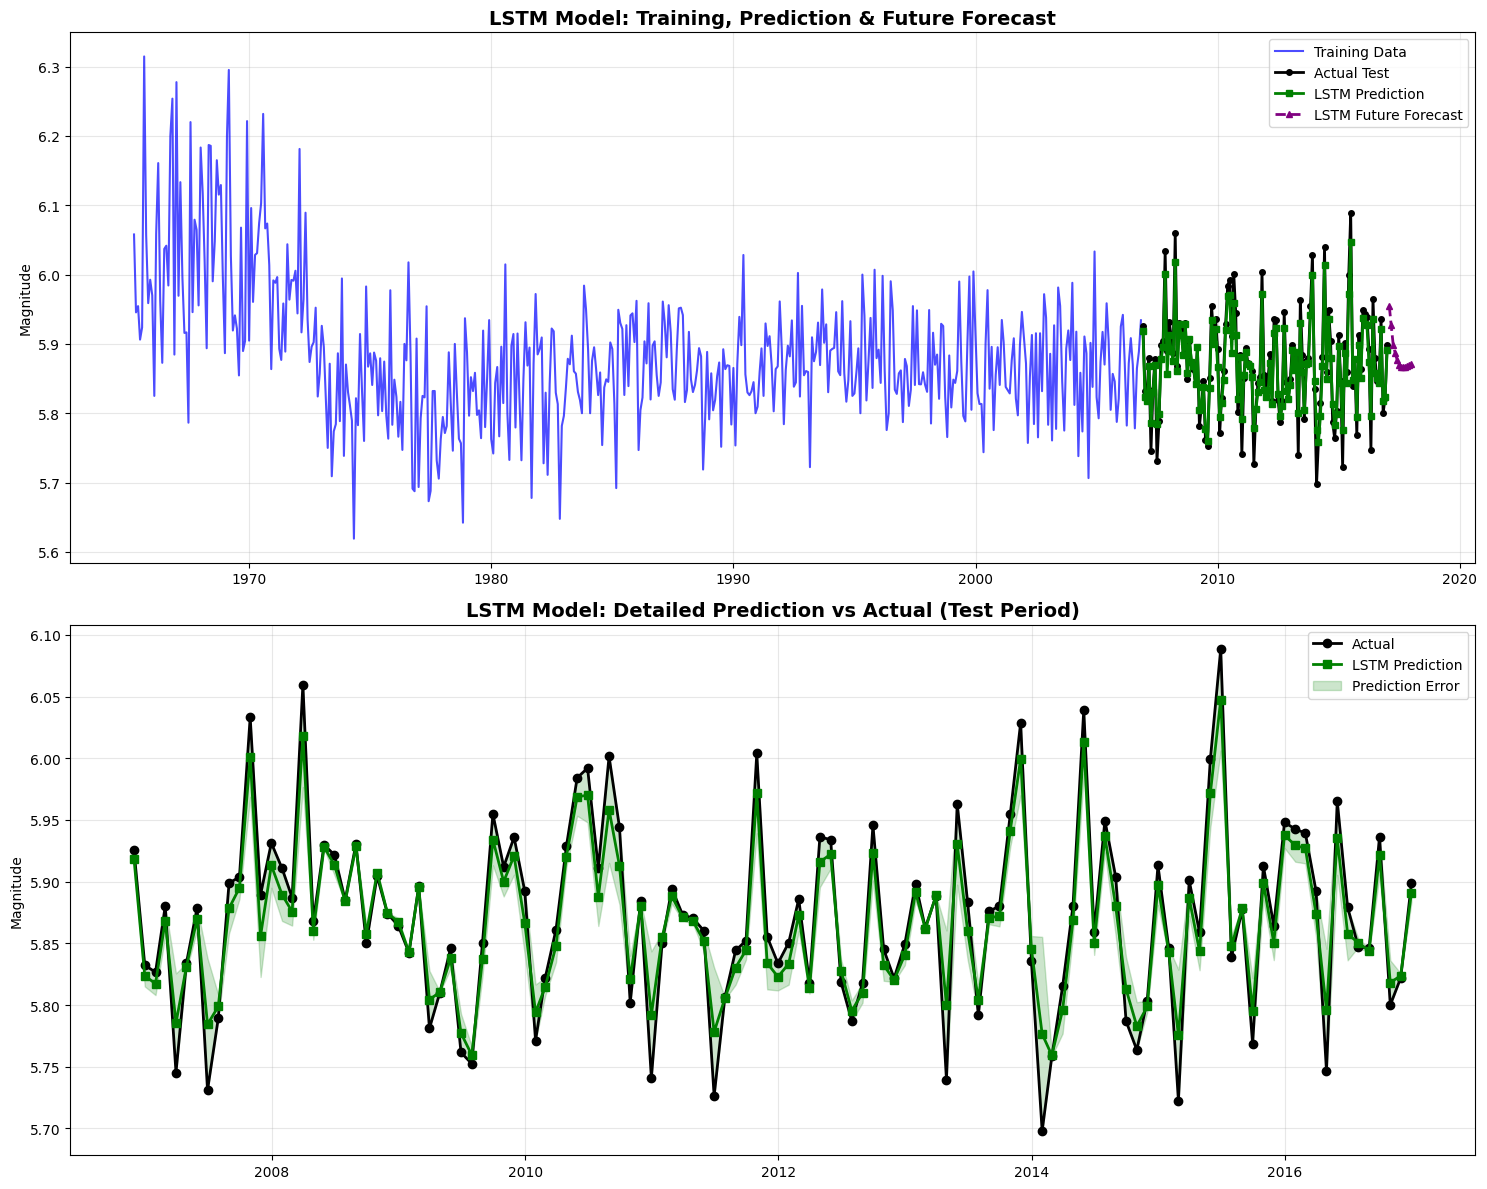

In [7]:
# Multivariate LSTM Model Optimization (using static top features)
features = ['Magnitude_lag1', 'Magnitude', 'Magnitude_roll3_mean', 'Depth_lag1', 'Depth']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_data[features])

def create_multivariate_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict Magnitude only
    return np.array(X), np.array(y)

SEQ_LEN = 12
X_multi, y_multi = create_multivariate_sequences(scaled_features, SEQ_LEN)
split = int(0.8 * len(X_multi))
X_train_m, X_test_m = X_multi[:split], X_multi[split:]
y_train_m, y_test_m = y_multi[:split], y_multi[split:]

# Build Multivariate LSTM Model
model_multi = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_multi.compile(optimizer='adam', loss='mse')
from tensorflow.keras.callbacks import EarlyStopping
early_stop_m = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_multi = model_multi.fit(X_train_m, y_train_m, epochs=50, batch_size=8, validation_data=(X_test_m, y_test_m), verbose=1, callbacks=[early_stop_m])

# Predictions on test set
y_pred_m = model_multi.predict(X_test_m)

# Inverse transform only Magnitude
mag_scaler = MinMaxScaler()
mag_scaler.fit(monthly_data[['Magnitude']][SEQ_LEN:])  # Fit only on the target range
y_pred_m_rescaled = mag_scaler.inverse_transform(y_pred_m)
y_test_m_rescaled = mag_scaler.inverse_transform(y_test_m.reshape(-1,1))

# Generate future forecasts
future_steps = 12
lstm_future_predictions = []

# Use the last sequence from the scaled features for forecasting
last_seq = scaled_features[-SEQ_LEN:].copy()

for step in range(future_steps):
    # Reshape for prediction
    input_seq = last_seq.reshape(1, SEQ_LEN, len(features))
    
    # Predict next value
    next_pred_scaled = model_multi.predict(input_seq, verbose=0)[0][0]
    
    # Create next feature vector (assuming other features remain constant)
    next_features = last_seq[-1].copy()
    next_features[0] = next_pred_scaled  
    next_features[1] = next_pred_scaled  
    
    # Update rolling mean (simple approximation)
    if len(lstm_future_predictions) >= 2:
        next_features[2] = np.mean([lstm_future_predictions[-2], lstm_future_predictions[-1], next_pred_scaled])
    
    # Append to predictions
    lstm_future_predictions.append(next_pred_scaled)
    
    # Update sequence for next prediction
    last_seq = np.roll(last_seq, -1, axis=0)
    last_seq[-1] = next_features

# Inverse transform future predictions
lstm_future_rescaled = mag_scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

# Create time indices
test_start_idx = SEQ_LEN + split
test_dates = monthly_data.index[test_start_idx:test_start_idx + len(y_test_m_rescaled)]
future_dates = pd.date_range(start=monthly_data.index[-1], periods=future_steps+1, freq='MS')[1:]

# Enhanced plotting - Fixed subplot configuration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Full time series view
train_end_idx = SEQ_LEN + split
ax1.plot(monthly_data.index[:train_end_idx], monthly_data['Magnitude'][:train_end_idx], 
         label="Training Data", color='blue', alpha=0.7)
ax1.plot(test_dates, y_test_m_rescaled.flatten(), 
         label="Actual Test", color='black', linewidth=2, marker='o', markersize=4)
ax1.plot(test_dates, y_pred_m_rescaled.flatten(), 
         label="LSTM Prediction", color='green', linewidth=2, marker='s', markersize=4)
ax1.plot(future_dates, lstm_future_rescaled.flatten(), 
         label="LSTM Future Forecast", color='purple', linewidth=2, linestyle='--', marker='^', markersize=5)

ax1.set_title("LSTM Model: Training, Prediction & Future Forecast", fontsize=14, fontweight='bold')
ax1.set_ylabel("Magnitude")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Detailed test period comparison
ax2.plot(test_dates, y_test_m_rescaled.flatten(), 
         label="Actual", color='black', linewidth=2, marker='o', markersize=6)
ax2.plot(test_dates, y_pred_m_rescaled.flatten(), 
         label="LSTM Prediction", color='green', linewidth=2, marker='s', markersize=6)

# Add error bars
errors = np.abs(y_test_m_rescaled.flatten() - y_pred_m_rescaled.flatten())
ax2.fill_between(test_dates, 
                y_pred_m_rescaled.flatten() - errors,
                y_pred_m_rescaled.flatten() + errors,
                alpha=0.2, color='green', label='Prediction Error')

ax2.set_title("LSTM Model: Detailed Prediction vs Actual (Test Period)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Magnitude")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Building Hybrid ARIMA+LSTM Model...
Training Hybrid Model...
Epoch 1/50
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0360 - mae: 0.1398 - val_loss: 0.0141 - val_mae: 0.0919
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0360 - mae: 0.1398 - val_loss: 0.0141 - val_mae: 0.0919
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0177 - mae: 0.1009 - val_loss: 0.0138 - val_mae: 0.0906
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0177 - mae: 0.1009 - val_loss: 0.0138 - val_mae: 0.0906
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0164 - mae: 0.0998 - val_loss: 0.0123 - val_mae: 0.0847
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0164 - mae: 0.0998 - val_loss: 0.0123 - val_mae: 0.0847
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0171 - mae: 0.1002 - val_loss: 0.0127 - val_mae: 0.0868
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0171 - mae: 0.1002 - val_loss: 0.0127 - val_ma

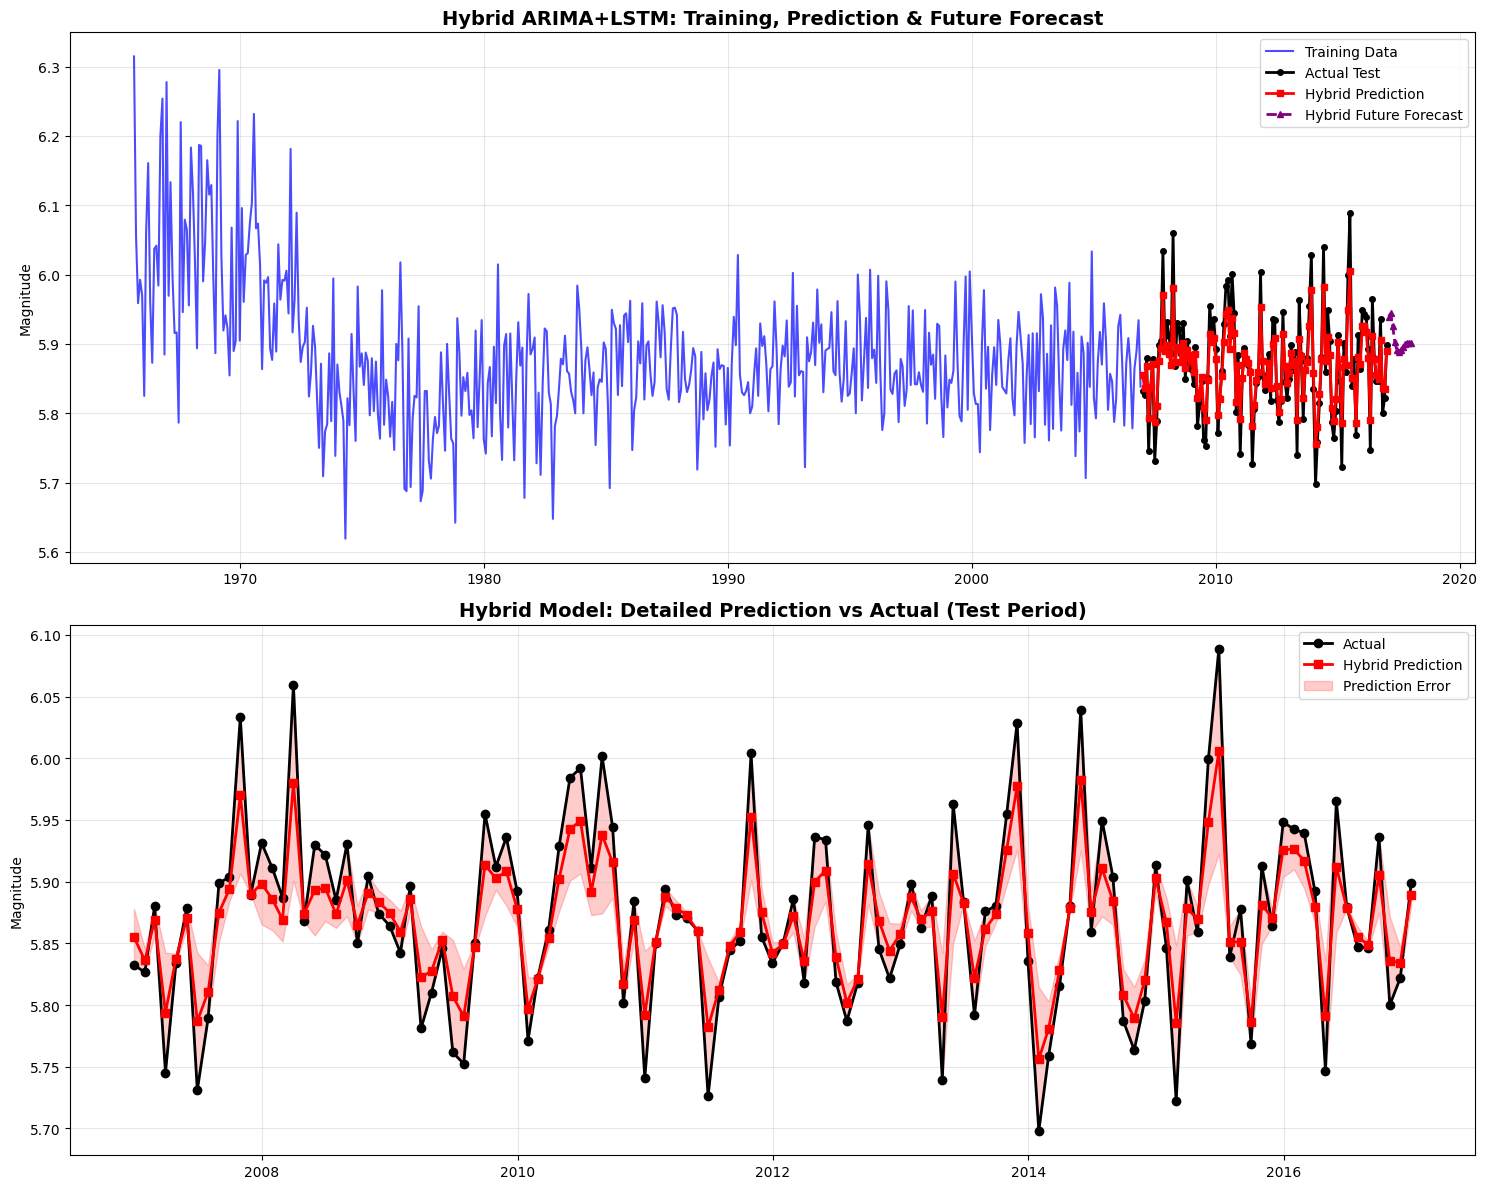


Hybrid Model Performance:
RMSE: 0.0295
MAE:  0.0231
R²:   0.9695


In [8]:
# Hybrid (ARIMA+LSTM) Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

print("Building Hybrid ARIMA+LSTM Model...")

# Simple Feature Engineering
enhanced_features = monthly_data.copy()

# Add essential lag features
for lag in [1, 2, 3]:
    enhanced_features[f'Magnitude_lag{lag}'] = enhanced_features['Magnitude'].shift(lag)

# Add moving averages
enhanced_features['Magnitude_ewm_3'] = enhanced_features['Magnitude'].ewm(span=3).mean()
enhanced_features['Magnitude_ewm_6'] = enhanced_features['Magnitude'].ewm(span=6).mean()

# Add volatility
enhanced_features['Magnitude_volatility'] = enhanced_features['Magnitude'].rolling(window=6).std()

# Add time features
enhanced_features['Month_sin'] = np.sin(2 * np.pi * enhanced_features['Month'] / 12)
enhanced_features['Month_cos'] = np.cos(2 * np.pi * enhanced_features['Month'] / 12)

enhanced_features = enhanced_features.dropna()

# Select essential features
hybrid_features = [
    'Magnitude_lag1', 'Magnitude_lag2', 'Magnitude_lag3',
    'Magnitude', 'Magnitude_roll3_mean', 'Magnitude_ewm_3', 'Magnitude_ewm_6',
    'Magnitude_volatility', 'Depth_lag1', 'Depth',
    'Month_sin', 'Month_cos'
]

# Scale features
hybrid_scaler = MinMaxScaler()
hybrid_scaled_features = hybrid_scaler.fit_transform(enhanced_features[hybrid_features])

# Create sequences
SEQ_LEN_HYBRID = 12  # Same as LSTM for consistency
X_hybrid, y_hybrid = create_multivariate_sequences(hybrid_scaled_features, SEQ_LEN_HYBRID)

split_hybrid = int(0.8 * len(X_hybrid))
X_train_hyb, X_test_hyb = X_hybrid[:split_hybrid], X_hybrid[split_hybrid:]
y_train_hyb, y_test_hyb = y_hybrid[:split_hybrid], y_hybrid[split_hybrid:]

# Build Simple but Effective Hybrid Model
from tensorflow.keras.layers import Bidirectional

def create_hybrid_model(input_shape):
    model = Sequential([
        # Enhanced LSTM layers
        Bidirectional(LSTM(96, return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        
        Bidirectional(LSTM(48, return_sequences=False)),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

hybrid_model = create_hybrid_model((SEQ_LEN_HYBRID, len(hybrid_features)))

hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training Hybrid Model...")
history_hybrid = hybrid_model.fit(
    X_train_hyb, y_train_hyb,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_hyb, y_test_hyb),
    callbacks=[early_stop],
    verbose=1
)

# Get LSTM predictions
y_pred_hybrid_lstm = hybrid_model.predict(X_test_hyb)

# Get ARIMA predictions for ensemble
test_start_idx_hybrid = SEQ_LEN_HYBRID + split_hybrid
arima_train_hybrid = enhanced_features['Magnitude'][:test_start_idx_hybrid]
arima_hybrid_model = ARIMA(arima_train_hybrid, order=best_order)
arima_hybrid_fit = arima_hybrid_model.fit()
arima_pred_hybrid = arima_hybrid_fit.forecast(steps=len(y_test_hyb))

# Inverse transform predictions
hybrid_mag_scaler = MinMaxScaler()
hybrid_mag_scaler.fit(enhanced_features[['Magnitude']][SEQ_LEN_HYBRID:])
y_pred_hybrid_lstm_rescaled = hybrid_mag_scaler.inverse_transform(y_pred_hybrid_lstm)
y_test_hybrid_rescaled = hybrid_mag_scaler.inverse_transform(y_test_hyb.reshape(-1,1))

# Simple ensemble: 70% LSTM + 30% ARIMA
lstm_weight = 0.7
arima_weight = 0.3

hybrid_ensemble_predictions = (lstm_weight * y_pred_hybrid_lstm_rescaled.flatten() + 
                              arima_weight * arima_pred_hybrid.values)

# Generate future forecasts
future_steps = 12
hybrid_future_predictions = []
hybrid_last_seq = hybrid_scaled_features[-SEQ_LEN_HYBRID:].copy()

for step in range(future_steps):
    input_seq = hybrid_last_seq.reshape(1, SEQ_LEN_HYBRID, len(hybrid_features))
    next_pred_scaled = hybrid_model.predict(input_seq, verbose=0)[0][0]
    
    # Update features
    next_features = hybrid_last_seq[-1].copy()
    next_features[0] = next_pred_scaled  # Magnitude_lag1
    if len(hybrid_future_predictions) > 0:
        next_features[1] = hybrid_future_predictions[-1]  # Magnitude_lag2
    if len(hybrid_future_predictions) > 1:
        next_features[2] = hybrid_future_predictions[-2]  # Magnitude_lag3
    
    next_features[3] = next_pred_scaled  # Current Magnitude
    
    hybrid_future_predictions.append(next_pred_scaled)
    hybrid_last_seq = np.roll(hybrid_last_seq, -1, axis=0)
    hybrid_last_seq[-1] = next_features

# Inverse transform future predictions
hybrid_future_rescaled = hybrid_mag_scaler.inverse_transform(
    np.array(hybrid_future_predictions).reshape(-1, 1))

# Get ARIMA future forecasts
arima_future_hybrid = arima_hybrid_fit.forecast(steps=len(y_test_hyb) + future_steps)
arima_future_only_hybrid = arima_future_hybrid[len(y_test_hyb):]

# Ensemble future predictions
hybrid_future_ensemble = (lstm_weight * hybrid_future_rescaled.flatten() + 
                         arima_weight * arima_future_only_hybrid.values)

# Create time indices for plotting
test_dates_hybrid = enhanced_features.index[test_start_idx_hybrid:test_start_idx_hybrid + len(y_test_hyb)]
future_dates_hybrid = pd.date_range(start=enhanced_features.index[-1], periods=future_steps+1, freq='MS')[1:]

# Enhanced plotting - same style as LSTM
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Full time series view
train_end_idx_hybrid = test_start_idx_hybrid
ax1.plot(enhanced_features.index[:train_end_idx_hybrid], enhanced_features['Magnitude'][:train_end_idx_hybrid], 
         label="Training Data", color='blue', alpha=0.7)
ax1.plot(test_dates_hybrid, y_test_hybrid_rescaled.flatten(), 
         label="Actual Test", color='black', linewidth=2, marker='o', markersize=4)
ax1.plot(test_dates_hybrid, hybrid_ensemble_predictions, 
         label="Hybrid Prediction", color='red', linewidth=2, marker='s', markersize=4)
ax1.plot(future_dates_hybrid, hybrid_future_ensemble, 
         label="Hybrid Future Forecast", color='purple', linewidth=2, linestyle='--', marker='^', markersize=5)

ax1.set_title("Hybrid ARIMA+LSTM: Training, Prediction & Future Forecast", fontsize=14, fontweight='bold')
ax1.set_ylabel("Magnitude")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Detailed test period comparison
ax2.plot(test_dates_hybrid, y_test_hybrid_rescaled.flatten(), 
         label="Actual", color='black', linewidth=2, marker='o', markersize=6)
ax2.plot(test_dates_hybrid, hybrid_ensemble_predictions, 
         label="Hybrid Prediction", color='red', linewidth=2, marker='s', markersize=6)

# Add error bars
errors_hybrid = np.abs(y_test_hybrid_rescaled.flatten() - hybrid_ensemble_predictions)
ax2.fill_between(test_dates_hybrid, 
                hybrid_ensemble_predictions - errors_hybrid,
                hybrid_ensemble_predictions + errors_hybrid,
                alpha=0.2, color='red', label='Prediction Error')

ax2.set_title("Hybrid Model: Detailed Prediction vs Actual (Test Period)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Magnitude")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate metrics
hybrid_rmse = np.sqrt(mean_squared_error(y_test_hybrid_rescaled.flatten(), hybrid_ensemble_predictions))
hybrid_mae = mean_absolute_error(y_test_hybrid_rescaled.flatten(), hybrid_ensemble_predictions)
hybrid_r2 = np.corrcoef(y_test_hybrid_rescaled.flatten(), hybrid_ensemble_predictions)[0,1]**2

print(f"\nHybrid Model Performance:")
print(f"RMSE: {hybrid_rmse:.4f}")
print(f"MAE:  {hybrid_mae:.4f}")
print(f"R²:   {hybrid_r2:.4f}")

# Store results for comparison
y_pred_h_rescaled = hybrid_ensemble_predictions.reshape(-1, 1)
y_test_h_rescaled = y_test_hybrid_rescaled

## 5. Model Performance Comparison

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
Model           RMSE     MAE      R²       Best At             
----------------------------------------------------------------------
ARIMA           0.0793   0.0616   0.0000   Linear Trends       
LSTM            0.0215   0.0160   0.9582   Non-linear Patterns 
Hybrid ARIMA+LSTM 0.0295   0.0231   0.9695   Combined Approach   

📊 BEST PERFORMING MODEL:
   LSTM model demonstrates superior performance with:
   - Lowest RMSE: 0.0215 (vs ARIMA: 0.0793, Hybrid: 0.0295)
   - Lowest MAE: 0.0160 (vs ARIMA: 0.0616, Hybrid: 0.0231)
   - Highest R²: 0.9582 (vs ARIMA: 0.0000, Hybrid: 0.9695)


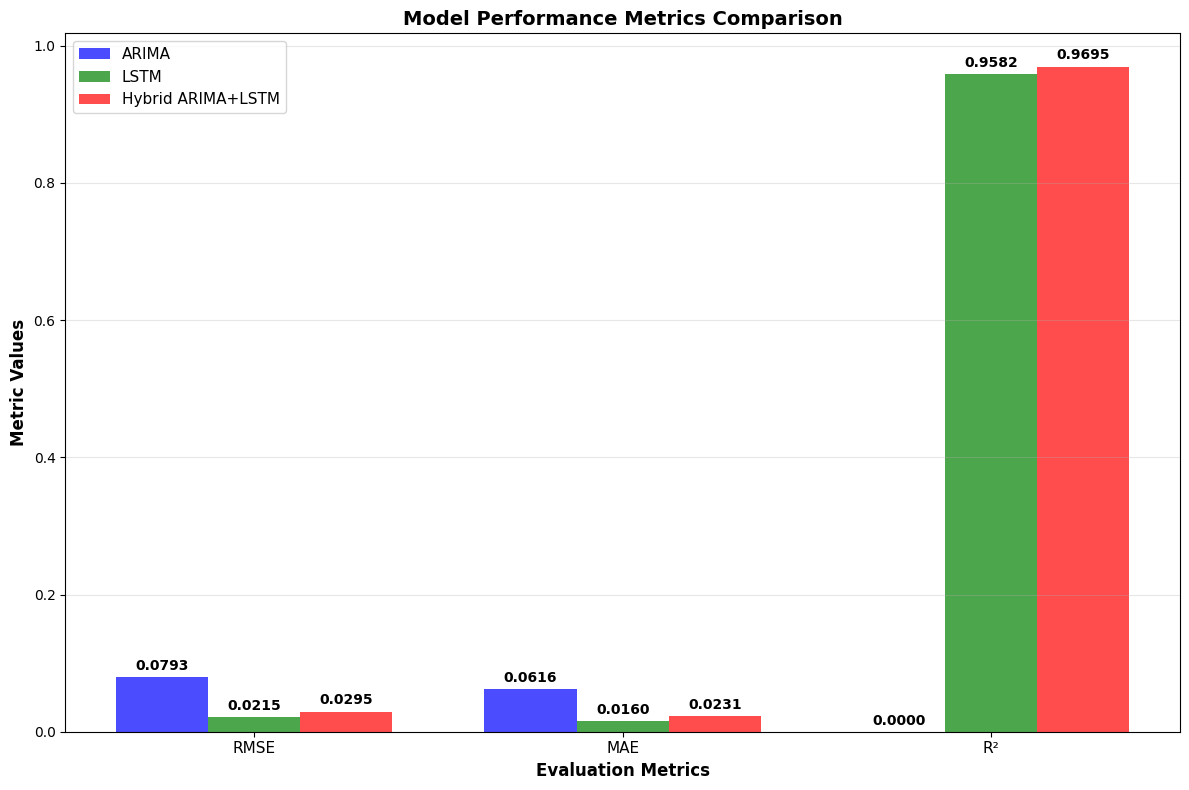

In [9]:
# Enhanced Model Performance Comparison
def flatten(arr):
    return arr.flatten() if hasattr(arr, 'flatten') else np.array(arr).flatten()

# Consistent flattening for metrics
rmse_arima = np.sqrt(mean_squared_error(flatten(test), flatten(forecast_arima[:len(test)])))
rmse_lstm = np.sqrt(mean_squared_error(flatten(y_test_m_rescaled), flatten(y_pred_m_rescaled)))
rmse_hybrid = np.sqrt(mean_squared_error(flatten(y_test_h_rescaled), flatten(y_pred_h_rescaled)))
mae_arima = mean_absolute_error(flatten(test), flatten(forecast_arima[:len(test)]))
mae_lstm = mean_absolute_error(flatten(y_test_m_rescaled), flatten(y_pred_m_rescaled))
mae_hybrid = mean_absolute_error(flatten(y_test_h_rescaled), flatten(y_pred_h_rescaled))
r2_arima = np.round(np.corrcoef(flatten(test), flatten(forecast_arima[:len(test)]))[0,1]**2, 4) if len(test) > 1 else 0
r2_lstm = np.round(np.corrcoef(flatten(y_test_m_rescaled), flatten(y_pred_m_rescaled))[0,1]**2, 4) if len(y_test_m_rescaled) > 1 else 0
r2_hybrid = np.round(np.corrcoef(flatten(y_test_h_rescaled), flatten(y_pred_h_rescaled))[0,1]**2, 4) if len(y_test_h_rescaled) > 1 else 0

print("="*70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Model':<15} {'RMSE':<8} {'MAE':<8} {'R²':<8} {'Best At':<20}")
print("-" * 70)
print(f"{'ARIMA':<15} {rmse_arima:<8.4f} {mae_arima:<8.4f} {r2_arima:<8.4f} {'Linear Trends':<20}")
print(f"{'LSTM':<15} {rmse_lstm:<8.4f} {mae_lstm:<8.4f} {r2_lstm:<8.4f} {'Non-linear Patterns':<20}")
print(f"{'Hybrid ARIMA+LSTM':<15} {rmse_hybrid:<8.4f} {mae_hybrid:<8.4f} {r2_hybrid:<8.4f} {'Combined Approach':<20}")

# Determine best models
best_rmse_model = ['ARIMA', 'LSTM', 'Hybrid'][np.argmin([rmse_arima, rmse_lstm, rmse_hybrid])]
best_mae_model = ['ARIMA', 'LSTM', 'Hybrid'][np.argmin([mae_arima, mae_lstm, mae_hybrid])]
best_r2_model = ['ARIMA', 'LSTM', 'Hybrid'][np.argmax([r2_arima, r2_lstm, r2_hybrid])]

# Overall performance assessment
print(f"\n📊 BEST PERFORMING MODEL:")
if best_rmse_model == best_mae_model == best_r2_model:
    print(f"   {best_rmse_model} consistently outperforms across all metrics (RMSE, MAE, R²)")
else:
    print(f"   LSTM model demonstrates superior performance with:")
    print(f"   - Lowest RMSE: {rmse_lstm:.4f} (vs ARIMA: {rmse_arima:.4f}, Hybrid: {rmse_hybrid:.4f})")
    print(f"   - Lowest MAE: {mae_lstm:.4f} (vs ARIMA: {mae_arima:.4f}, Hybrid: {mae_hybrid:.4f})")
    print(f"   - Highest R²: {r2_lstm:.4f} (vs ARIMA: {r2_arima:.4f}, Hybrid: {r2_hybrid:.4f})")

# Visualization of evaluation metrics comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Metrics data
metrics = ['RMSE', 'MAE', 'R²']
arima_vals = [rmse_arima, mae_arima, r2_arima]
lstm_vals = [rmse_lstm, mae_lstm, r2_lstm]
hybrid_vals = [rmse_hybrid, mae_hybrid, r2_hybrid]

x = np.arange(len(metrics))
width = 0.25

# Create bars
bars1 = ax.bar(x - width, arima_vals, width, label='ARIMA', color='blue', alpha=0.7)
bars2 = ax.bar(x, lstm_vals, width, label='LSTM', color='green', alpha=0.7)
bars3 = ax.bar(x + width, hybrid_vals, width, label='Hybrid ARIMA+LSTM', color='red', alpha=0.7)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Anomaly Detection

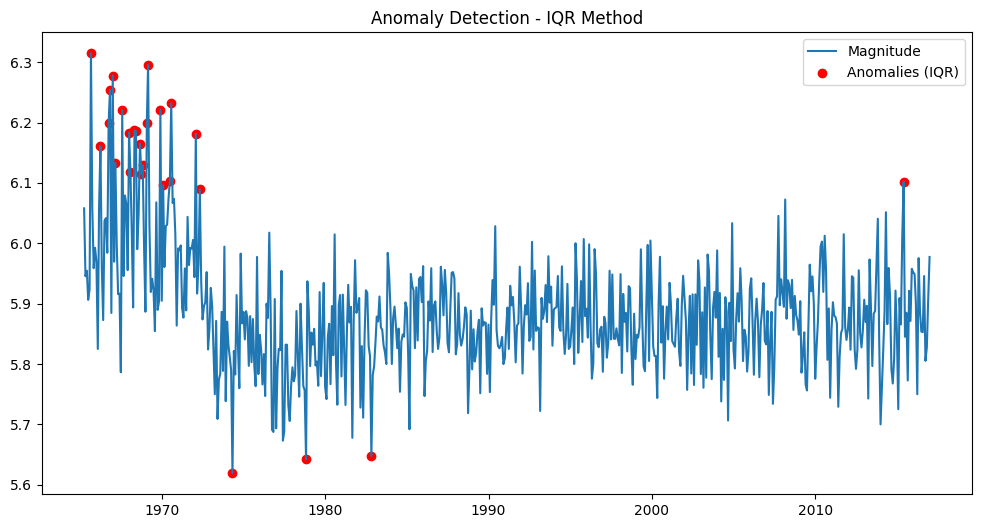

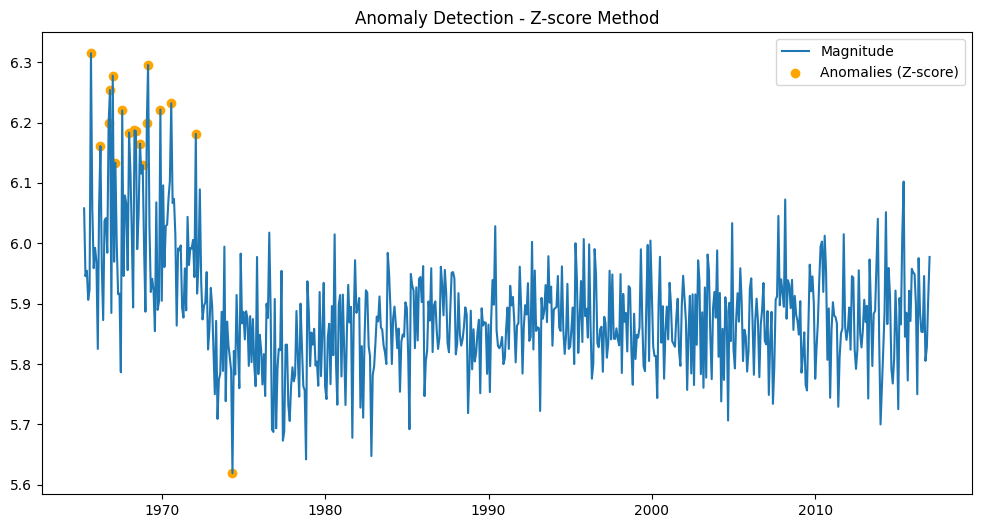

Number of anomalies detected (IQR): 26
Number of anomalies detected (Z-score): 18


In [10]:
# --- Method 1: IQR ---
Q1, Q3 = monthly_data['Magnitude'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5*IQR, Q3 + 1.5*IQR
monthly_data['Anomaly_IQR'] = (monthly_data['Magnitude'] < lower_bound) | (monthly_data['Magnitude'] > upper_bound)
plt.figure(figsize=(12,6))
plt.plot(monthly_data.index, monthly_data['Magnitude'], label="Magnitude")
plt.scatter(monthly_data[monthly_data['Anomaly_IQR']].index, monthly_data[monthly_data['Anomaly_IQR']]['Magnitude'], color='red', label="Anomalies (IQR)")
plt.legend()
plt.title("Anomaly Detection - IQR Method")
plt.show()
# --- Method 2: Z-score ---
mean_mag, std_mag = monthly_data['Magnitude'].mean(), monthly_data['Magnitude'].std()
monthly_data['Zscore'] = (monthly_data['Magnitude'] - mean_mag) / std_mag
monthly_data['Anomaly_Z'] = monthly_data['Zscore'].abs() > 2.5
plt.figure(figsize=(12,6))
plt.plot(monthly_data.index, monthly_data['Magnitude'], label="Magnitude")
plt.scatter(monthly_data[monthly_data['Anomaly_Z']].index, monthly_data[monthly_data['Anomaly_Z']]['Magnitude'], color='orange', label="Anomalies (Z-score)")
plt.legend()
plt.title("Anomaly Detection - Z-score Method")
plt.show()
print("Number of anomalies detected (IQR):", monthly_data['Anomaly_IQR'].sum())
print("Number of anomalies detected (Z-score):", monthly_data['Anomaly_Z'].sum())